# Hamiltonian Neural Network - Hénon-Heiles System

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from Systems.HenonHeiles import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.HNN import *
from HamiltonianNeuralNetwork.Train import *
from NumericalIntegration.Numerical_Integration import *

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [62]:
def initial_condition(lam = 1):
    def sampler():
            """Function for sampling initial conditions. Callabale taking
                a numpy random generator as input and returning an ndarray
                of shape (nstates,) with inital conditions for the system."""
        
            x0= 0
            H0 = np.random.uniform(0,1/10)
            while True:
                y0 = np.random.uniform(-1,1)    
                py0 = np.random.uniform(-1,1)
                K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
                if K>= 0:
                    break
            px0 = np.sqrt(K)

            return np.array([x0,y0,px0,py0]).flatten()
    return sampler()

In [63]:
T_max_train = 5
nsamples_train = 100
ntraj_train = 1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750
epochs = 50

#Activations nn.Tanh(), nn.ReLU(), Sin(), nn.Softplus(), PAU(), PadeTypeActivation

act_1 = nn.Tanh()
act_2 = nn.ReLU()

lr = 1e-3
batch_size = 64
sys = HenonHeilesSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [64]:
def HenonHeiles_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt

loss_func = loss_wrapper(HenonHeiles_loss_func)

## Explicit Midpoint

  0%|          | 0/1750 [00:00<?, ?it/s]

100%|██████████| 50/50 [08:47<00:00, 10.56s/it, epoch=49, loss=3.23e-6]


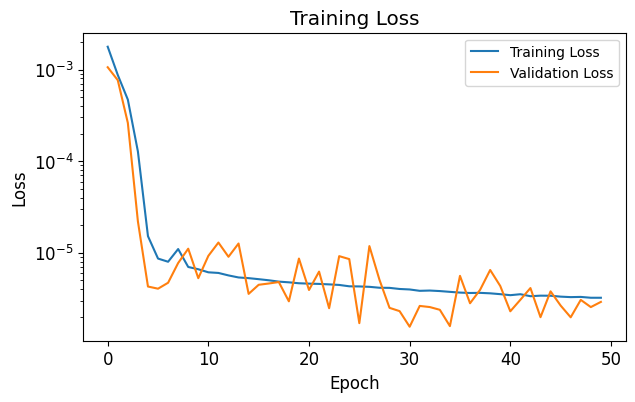

In [65]:
integrator = "midpoint"

(u_start, u_end, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, dt), dudt

model_exp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_explicit = trainer.train(loss_func)

### Predicting from Explicit Midpoint

In [75]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00, 100.23it/s]


In [67]:
def get_Hamiltonians(model,u_exact,u_pred,t_sample):
    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

    t = t_sample.squeeze(0)
    u_samples = u_pred.squeeze(0)
    #Computed estimated Hamiltonian from values for prediction
    H_nn= torch.tensor([(model.Hamiltonian(u)- model.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
    #Computed true Hamiltonian values for prediction
    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
    #Computed NN Hamiltonian for exact
    H_nn_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


    return H_exact, H_nn, H_exact_pred, H_nn_exact

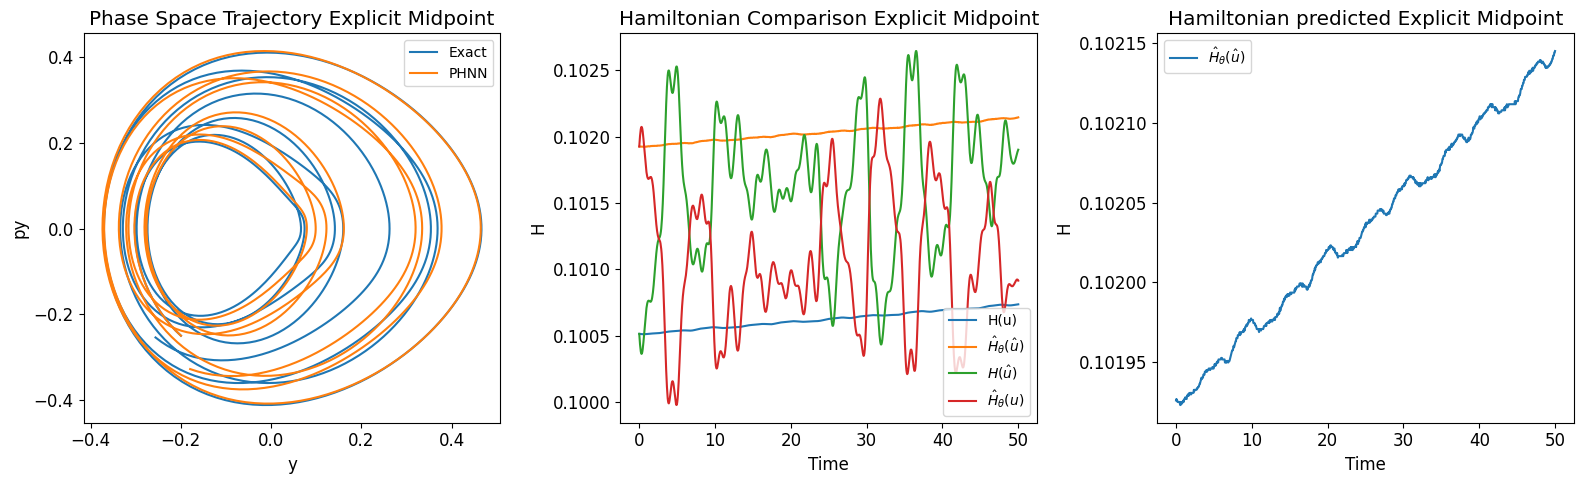

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_exp[0][:, 1], u_phnn_exp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Explicit Midpoint" )
ax[0].legend()


H_exact, H_exp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_exp,u_exact,u_phnn_exp,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Explicit Midpoint")
ax[1].legend()

ax[2].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Explicit Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()




## Symplectic Euler

100%|██████████| 50/50 [09:37<00:00, 11.56s/it, epoch=49, loss=3.6e-6] 


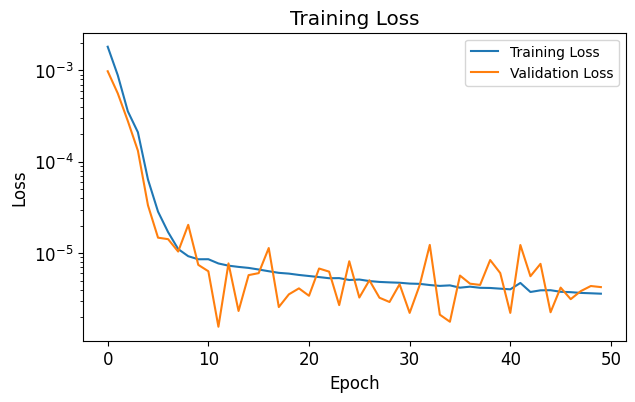

In [69]:
integrator = "symplectic euler"

(u_start, u_end, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, dt), dudt

model_symp_eul = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)

trainer = Training(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul, system = sys, batch_size=batch_size,epochs = epochs)
model_symp_eul, trainingdetails_symp_eul= trainer.train(loss_func)

### Predicting from Symplectic Euler

In [70]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp_eul, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


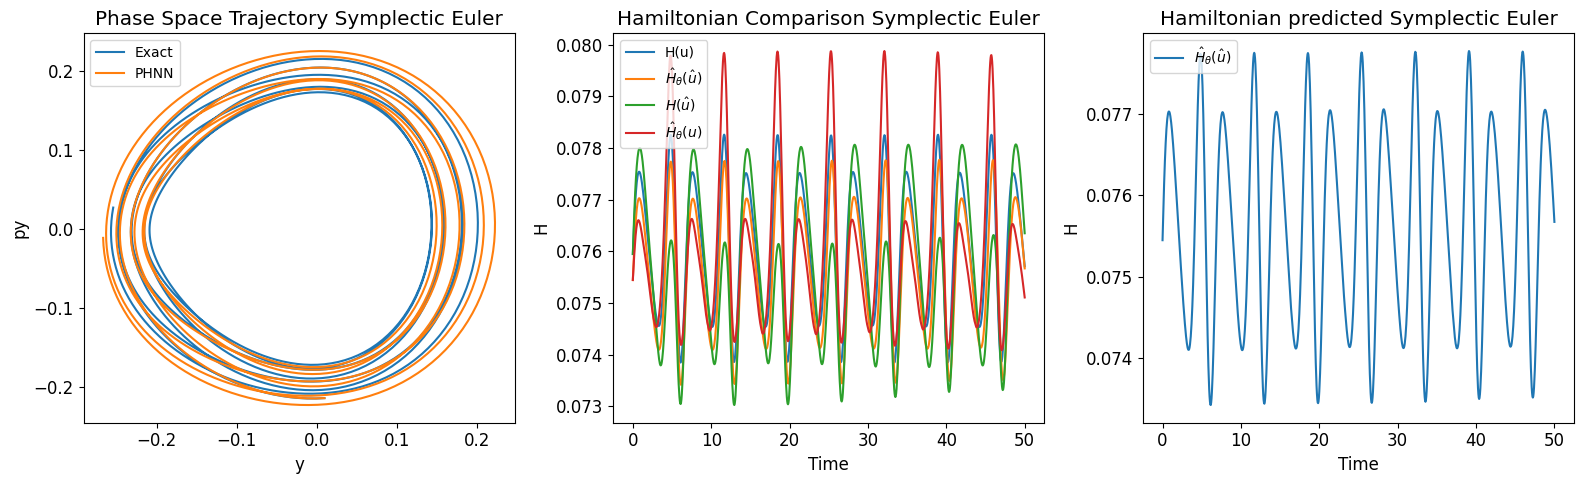

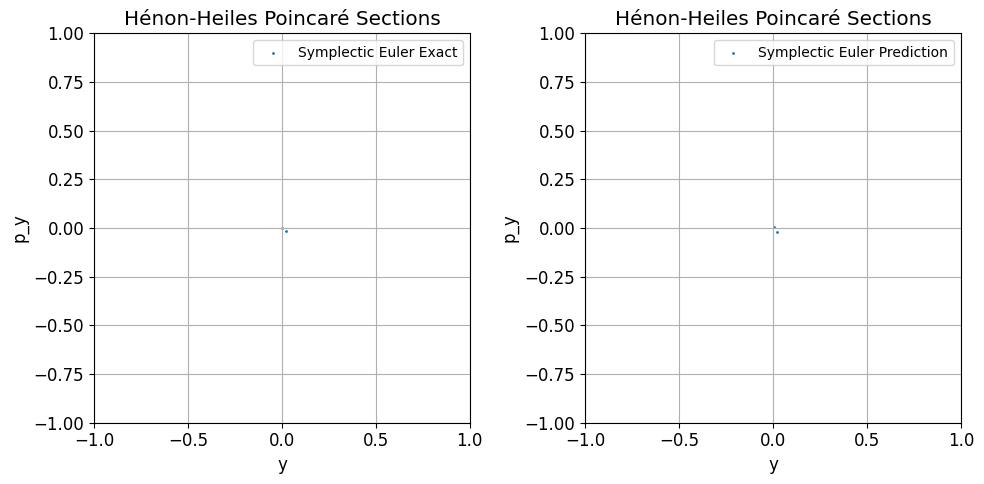

In [71]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp_eul[0][:, 1], u_phnn_symp_eul[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Euler" )
ax[0].legend()

H_exact, H_symp_eul_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_symp_eul,u_exact,u_phnn_symp_eul,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_eul_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Euler")
ax[1].legend()

ax[2].plot(t, H_symp_eul_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Euler")
ax[2].legend()

plt.tight_layout() 
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))  

event_indices = np.round(find_crossings(u_exact[0])).astype(int)
y_py = np.array([torch.tensor(u_exact[0][:,0][event_indices]), torch.tensor(u_exact[0][:,1][event_indices])]).T
ax[0].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Euler Exact")
ax[0].legend()
ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_xlabel("y")
ax[0].set_ylabel("p_y")
ax[0].set_title("Hénon-Heiles Poincaré Sections")
ax[0].grid(True)



event_indices = np.round(find_crossings(u_phnn_symp_eul[0])).astype(int)
y_py = np.array([u_phnn_symp_eul[0][:,0][event_indices], u_phnn_symp_eul[0][:,1][event_indices]]).T
ax[1].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Euler Prediction")
ax[1].legend()
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_xlabel("y")
ax[1].set_ylabel("p_y")
ax[1].set_title("Hénon-Heiles Poincaré Sections")
ax[1].grid(True)


plt.tight_layout() 
plt.show()

## Symplectic Midpoint

100%|██████████| 50/50 [06:54<00:00,  8.30s/it, epoch=49, loss=3.81e-6]


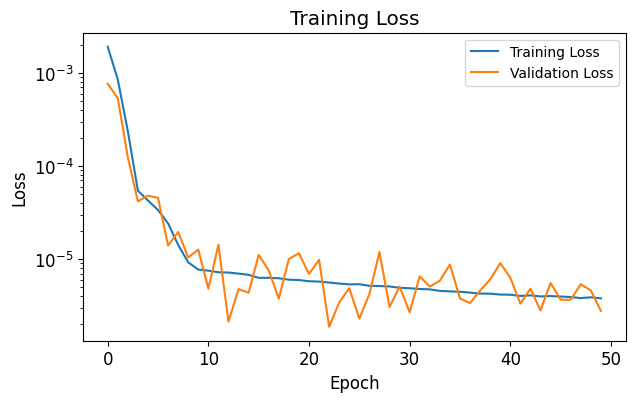

In [72]:
integrator = "symplectic midpoint"

(u_start, u_end, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, dt), dudt

model_symp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)

trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp_eul= trainer.train(loss_func)

### Predicting from Symplectic Midpoint

In [73]:
tmax = 5*100
nsamples = 100*100
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


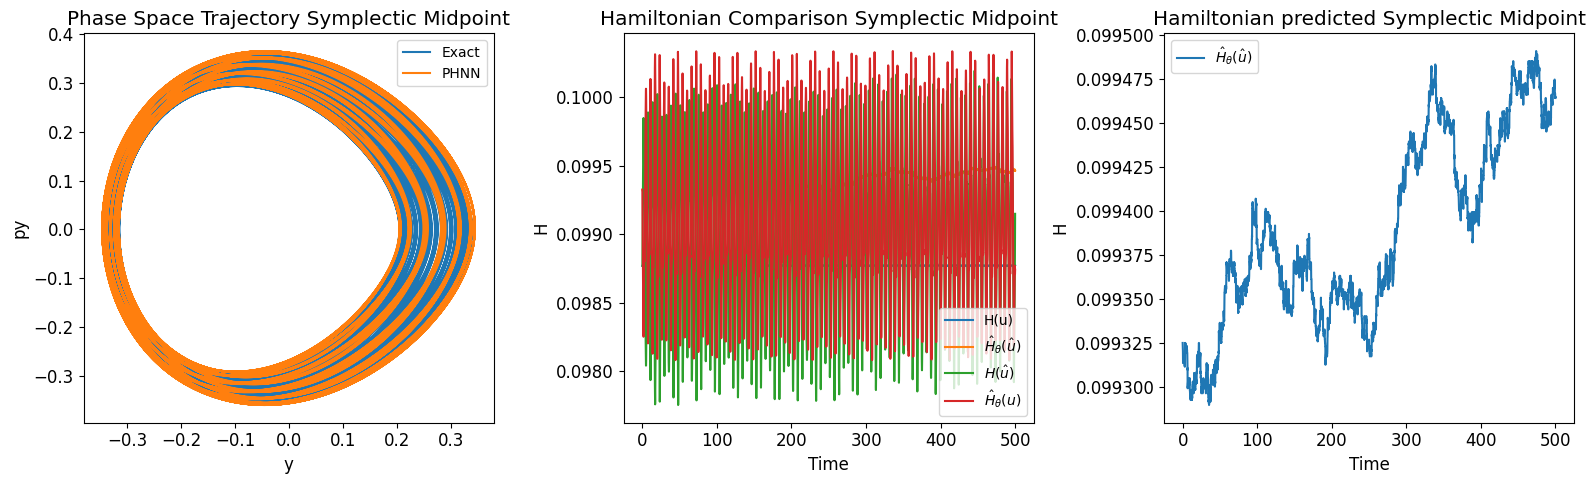

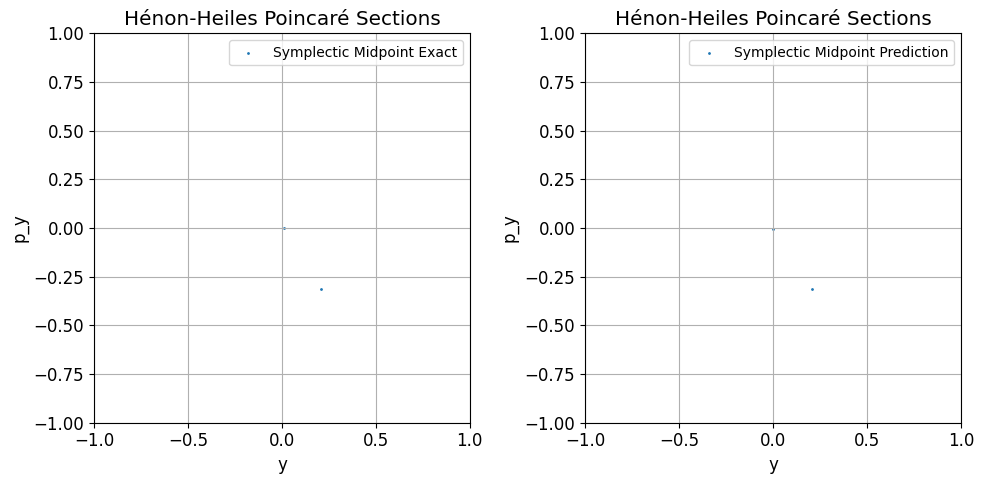

In [74]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint" )
ax[0].legend()

H_exact, H_symp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_symp,u_exact,u_phnn_symp,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))  

event_indices = np.round(find_crossings(u_exact[0])).astype(int)
y_py = np.array([torch.tensor(u_exact[0][:,0][event_indices]), torch.tensor(u_exact[0][:,1][event_indices])]).T
ax[0].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Midpoint Exact")
ax[0].legend()
ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_xlabel("y")
ax[0].set_ylabel("p_y")
ax[0].set_title("Hénon-Heiles Poincaré Sections")
ax[0].grid(True)



event_indices = np.round(find_crossings(u_phnn_symp[0])).astype(int)
y_py = np.array([u_phnn_symp[0][:,0][event_indices], u_phnn_symp[0][:,1][event_indices]]).T
ax[1].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Midpoint Prediction")
ax[1].legend()
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_xlabel("y")
ax[1].set_ylabel("p_y")
ax[1].set_title("Hénon-Heiles Poincaré Sections")
ax[1].grid(True)


plt.tight_layout() 
plt.show()